In [143]:
import numpy as np
import pandas as pd
import yfinance as yf
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from scipy.stats import norm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import pacf
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from itertools import product
from statsmodels.tsa.stattools import adfuller, kpss

In [463]:
# Load and prepare the data

# Define the stock name : ExxonMobil(XOM) and  Chevron(CVX)
stock_name = ['XOM', 'CVX']

# Download stock data
data = yf.download(stock_name, start="2021-01-01", end="2024-08-01")['Adj Close']

# Split data into training and test sets
train_data = data.loc[:'2024-06-1']
test_data = data.loc['2024-07-01':'2024-08-01']
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)



[*********************100%***********************]  2 of 2 completed


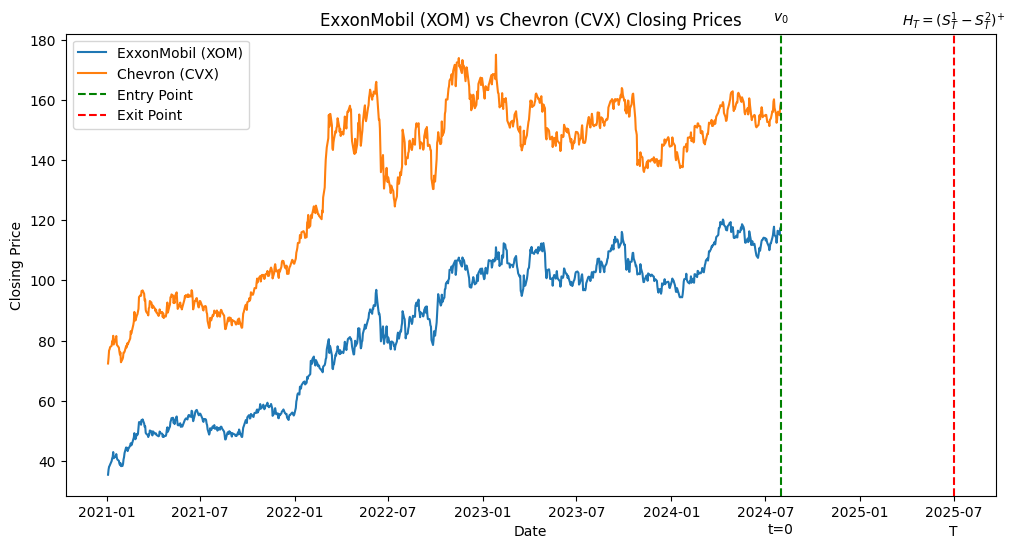

In [193]:
entry_date_str = '2024-07-31'
exit_date_str = '2025-07-01'

# Convert entry and exit dates to datetime objects
entry_date = pd.to_datetime(entry_date_str)
exit_date = pd.to_datetime(exit_date_str)

plt.figure(figsize=(12, 6))
# Plot the closing prices for ExxonMobil (XOM) and Chevron (CVX)
plt.plot(data['XOM'], label='ExxonMobil (XOM)')
plt.plot(data['CVX'], label='Chevron (CVX)')

# Add vertical dotted lines for entry and exit points
plt.axvline(x=entry_date, color='green', linestyle='--', label='Entry Point')

plt.text(entry_date, 15, 't=0', color='black', ha='center', va='bottom')
plt.text(entry_date, 187, r'$v_0$', color='black', ha='center', va='center')

plt.axvline(x=exit_date, color='red', linestyle='--', label='Exit Point')
plt.text(exit_date, 19, 'T', color='black', ha='center', va='top')
plt.text(exit_date, 190, r'$H_T=(S_T^1-S_T^2)^{+}$', color='black', ha='center', va='top')


plt.title('ExxonMobil (XOM) vs Chevron (CVX) Closing Prices')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()


In [146]:


# Define the stock names: ExxonMobil (XOM) and Chevron (CVX)
stock_names = ['XOM', 'CVX']

# Download stock data
data = yf.download(stock_names, start="2021-01-01", end="2024-08-01")['Adj Close']

# Convert prices to log returns
returns = np.log(data / data.shift(1)).dropna()

# Calculate mean and variance
mean = returns.mean()
variance = returns.var()
print("Mean:\n", mean)
print("Variance:\n", variance)

# Split data into training and validation sets

train_data, validation_data = train_test_split(returns, test_size=0.2, shuffle=False, random_state=42)

# Function to evaluate VAR model for different lag orders
def evaluate_lag_order(train, validation, max_lags):
    mse_results = {}

    for p in range(1, max_lags + 1):
        try:
            # Fit the VAR model with lag order p
            model = sm.tsa.VAR(train)
            model_fitted = model.fit(p)

            # Forecast on the validation set
            forecast = model_fitted.forecast(train.values[-p:], steps=len(validation))
            forecast_df = pd.DataFrame(forecast, index=validation.index, columns=train.columns)

            # Calculate mean squared error
            mse = mean_squared_error(validation, forecast_df)
            mse_results[p] = mse
            print(f"Lag order {p}: MSE = {mse}")

        except Exception as e:
            print(f"Error with lag order {p}: {e}")
            mse_results[p] = np.inf  # Assign a high MSE in case of error

    return mse_results

# Evaluate different lag orders
max_lags = 20  # Adjust this value based on your requirements
mse_results = evaluate_lag_order(train_data, validation_data, max_lags)

# Find the best lag order based on MSE
best_p = min(mse_results, key=mse_results.get)
print(f"Best lag order based on MSE: {best_p}")

# Fit the final model with the best lag order
model = sm.tsa.VAR(train_data)
results = model.fit(best_p)

# Forecast using the best model
forecast_steps = len(validation_data)
forecast = results.forecast(train_data.values[-best_p:], steps=forecast_steps)
forecast_df = pd.DataFrame(forecast, index=validation_data.index, columns=train_data.columns)



[*********************100%***********************]  2 of 2 completed

Mean:
 Ticker
CVX    0.000874
XOM    0.001336
dtype: float64
Variance:
 Ticker
CVX    0.000268
XOM    0.000325
dtype: float64
Lag order 1: MSE = 0.00012725341981738503
Lag order 2: MSE = 0.00012722595451965365
Lag order 3: MSE = 0.0001272088087515464
Lag order 4: MSE = 0.00012736394384248878
Lag order 5: MSE = 0.0001274507132819007
Lag order 6: MSE = 0.00012735677736772888
Lag order 7: MSE = 0.00012747611253229334
Lag order 8: MSE = 0.00012760408798746743
Lag order 9: MSE = 0.00012755177919277036
Lag order 10: MSE = 0.0001272103196913727
Lag order 11: MSE = 0.00012697667810864877
Lag order 12: MSE = 0.00012759331683587222
Lag order 13: MSE = 0.00012760097109579586
Lag order 14: MSE = 0.0001280820857575624
Lag order 15: MSE = 0.00012995873663082286
Lag order 16: MSE = 0.00012990859346811566
Lag order 17: MSE = 0.00013001098554550676
Lag order 18: MSE = 0.00013013604740081173
Lag order 19: MSE = 0.0001292743848542294
Lag order 20: MSE = 0.0001298298096087605
Best lag order based on MSE: 


c:\Users\Student\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Student\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Student\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Student\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has

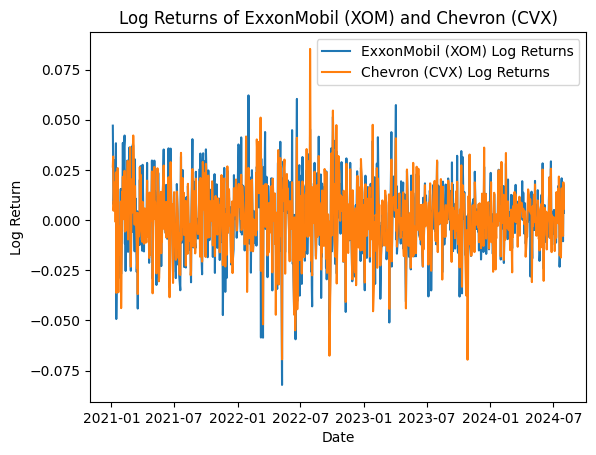

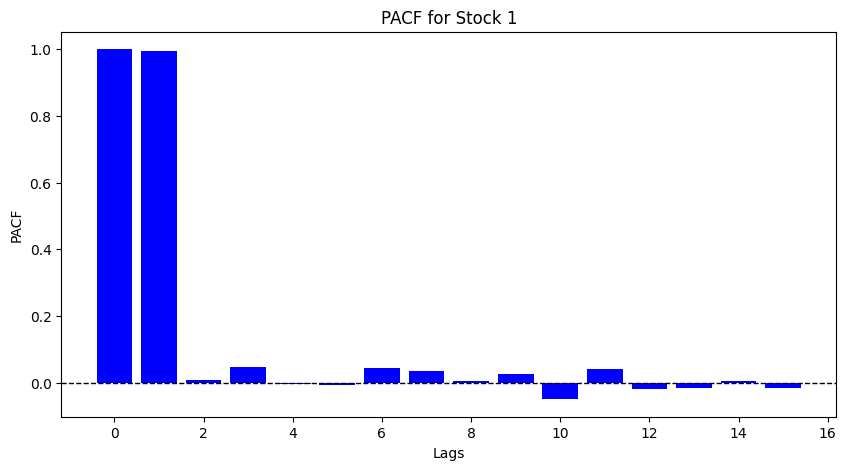

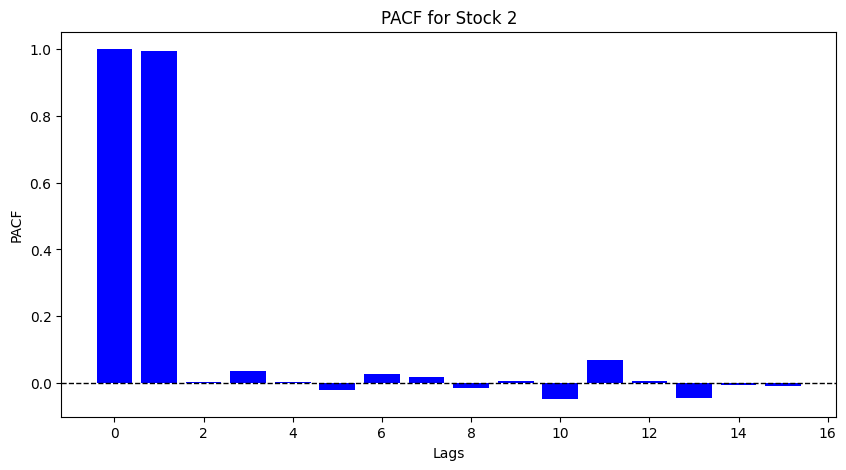

In [147]:


def plot_pacf(series, lags=10, title='PACF'):
    pacf_values = pacf(series, nlags=lags)
    plt.figure(figsize=(10, 5))
    plt.bar(range(len(pacf_values)), pacf_values, color='blue')
    plt.title(title)
    plt.xlabel('Lags')
    plt.ylabel('PACF')
    plt.axhline(0, color='black', linestyle='--', linewidth=1)
    plt.show()




plt.plot(returns.index, returns['XOM'], label='ExxonMobil (XOM) Log Returns')
plt.plot(returns.index, returns['CVX'], label='Chevron (CVX) Log Returns')
plt.title('Log Returns of ExxonMobil (XOM) and Chevron (CVX)')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.legend()


plot_pacf(data['XOM'], lags=15, title='PACF for Stock 1')
plot_pacf(data['CVX'], lags=15, title='PACF for Stock 2')

In [148]:
# Distribution check for the VAR model


[*********************100%***********************]  2 of 2 completed
c:\Users\Student\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Student\AppData\Local\Temp\ipykernel_1324\2523568889.py:81: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


(22400, 30, 2)
(22400, 30, 2)


C:\Users\Student\AppData\Roaming\Python\Python312\site-packages\IPython\core\events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\Users\Student\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


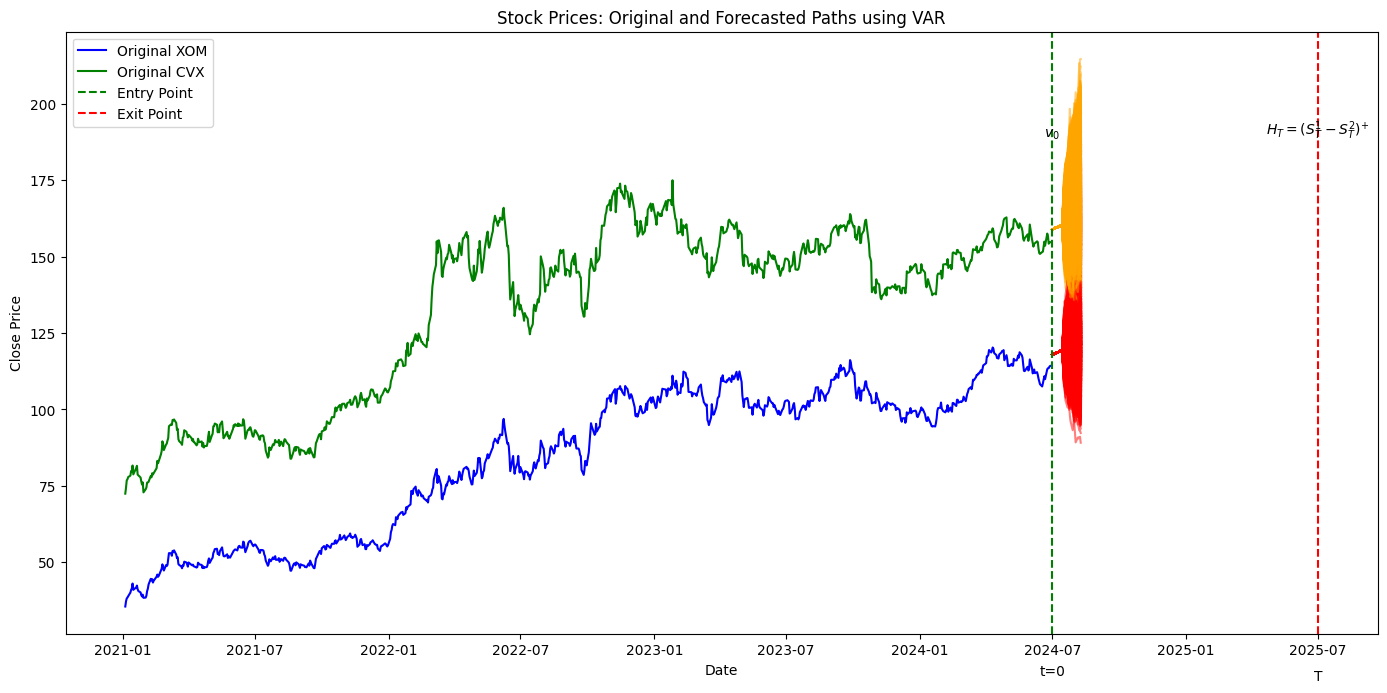

In [464]:


entry_date_str = '2024-07-31'
exit_date_str = '2026-07-01'


# Define the stock names: ExxonMobil (XOM) and Chevron (CVX)
stock_names = ['XOM', 'CVX']

# Download stock data
data = yf.download(stock_names, start="2021-01-01", end="2024-08-01")['Adj Close']
cutoff_date = '2024-06-30'

# Filter data up to the cutoff date
filtered_data = data.loc[:cutoff_date]
# Convert prices to log returns
log_returns = np.log(data / data.shift(1)).dropna()

# Split data into training and test sets
#train_data = log_returns.loc[:'2024-06-30']
#test_data = log_returns.loc['2024-07-01':]

# Fit the VAR model on training data
model = VAR(log_returns)
results = model.fit(maxlags=best_p)
#print(results.summary())


# Define forecast parameters
forecast_steps = 30
nsims =  22400  # Number of simulation paths

# Generate forecast paths
forecast_paths = results.simulate_var(steps=forecast_steps, nsimulations=nsims)
forecast_paths=(forecast_paths)

# Extract the last observed prices
last_observed_prices = data.iloc[-1].values

# Convert forecast paths from log returns to price levels
# Calculate cumulative returns
cumulative_returns = np.cumsum(forecast_paths, axis=1)
forecast_paths=last_observed_prices*np.exp(cumulative_returns)
# Adjust cumulative returns with the last observed prices
adjusted_forecast_paths = np.exp(cumulative_returns + np.log(last_observed_prices))
#adjusted_forecast_paths =last_observed_prices* np.exp(cumulative_returns )

# Convert forecast to DataFrame with correct date index
forecast_dates = pd.date_range(start='2024-07-01', periods=forecast_steps, freq='B')
forecast_df = pd.DataFrame(adjusted_forecast_paths[0, :, :], index=forecast_dates, columns=data.columns)  # Use one path to create a DataFrame

# Plot the original data and multiple forecast paths
plt.figure(figsize=(14, 7))

# Plot original data
plt.plot(filtered_data.index, filtered_data['XOM'], label='Original XOM', color='blue')
plt.plot(filtered_data.index, filtered_data['CVX'], label='Original CVX', color='green')

# Plot adjusted forecast paths for each simulation
for i in range(nsims):
    plt.plot(forecast_dates, adjusted_forecast_paths[i, :, 0], color='orange', alpha=0.5)
    plt.plot(forecast_dates, adjusted_forecast_paths[i, :, 1], color='red', alpha=0.5)

# Define entry and exit dates for vertical lines
entry_date = pd.Timestamp('2024-07-01')
exit_date = pd.Timestamp('2025-07-01')

# Add vertical dotted lines for entry and exit points
plt.axvline(x=entry_date, color='green', linestyle='--', label='Entry Point')

plt.text(entry_date, 12, 't=0', color='black', ha='center', va='bottom')
plt.text(entry_date, 190, r'$v_0$', color='black', ha='center', va='center')

plt.axvline(x=exit_date, color='red', linestyle='--', label='Exit Point')
plt.text(exit_date, 15, 'T', color='black', ha='center', va='top')
plt.text(exit_date, 195, r'$H_T=(S_T^1-S_T^2)^{+}$', color='black', ha='center', va='top')

plt.title('Stock Prices: Original and Forecasted Paths using VAR')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
#plt.grid(True)
plt.tight_layout()

#plt.show()
print(np.shape(forecast_paths))
print(np.shape(cumulative_returns))


In [150]:


forecast_paths=np.exp(cumulative_returns)



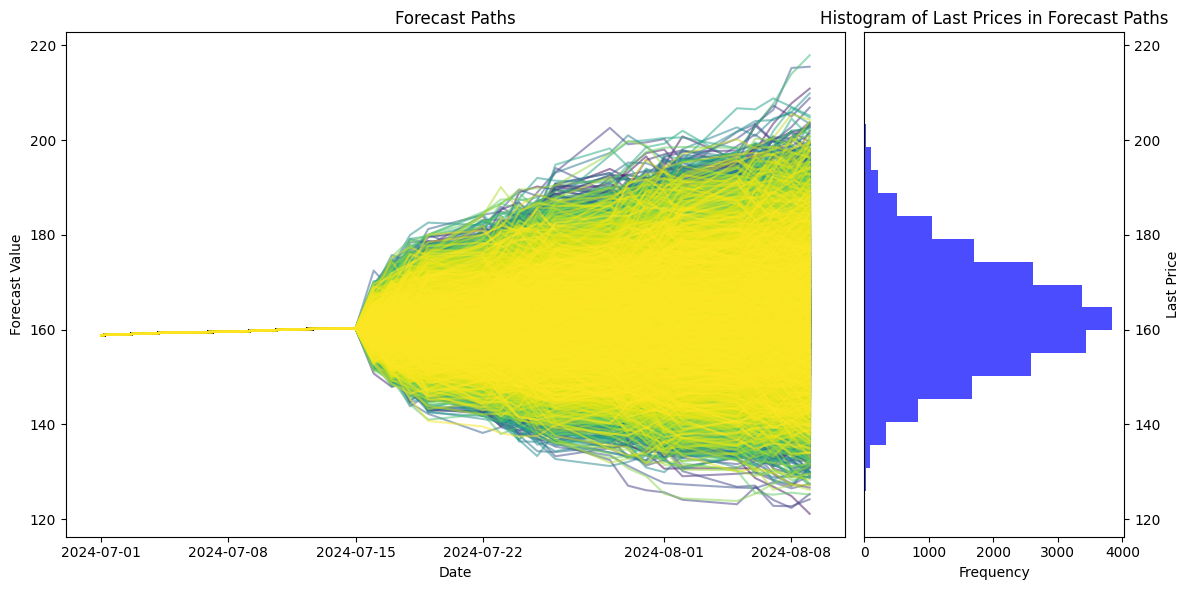

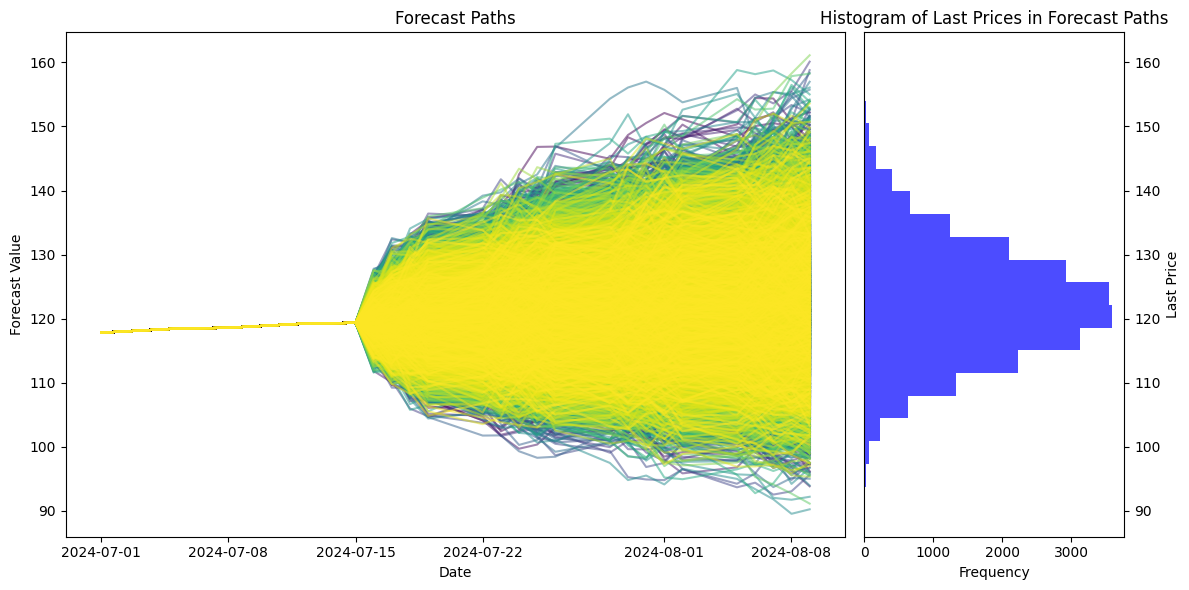

In [151]:
last_prices = adjusted_forecast_paths[:, -1, :]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'width_ratios': [3, 1]})
colors = plt.cm.viridis(np.linspace(0, 1, nsims))
# Plot the forecast paths on the first subplot
for i in range(nsims):
    ax1.plot(forecast_dates, adjusted_forecast_paths[i, :, 0], color=colors[i], alpha=0.5)

ax1.set_title('Forecast Paths')
ax1.set_xlabel('Date')
ax1.set_ylabel('Forecast Value')

# Create a histogram for the last prices on the second subplot
ax2.hist(last_prices[:,0], bins=20, alpha=0.7, color='blue', orientation='horizontal')
ax2.set_title('Histogram of Last Prices in Forecast Paths')
ax2.set_xlabel('Frequency')
ax2.set_ylabel('Last Price')

# Align the y-axis of the histogram with the y-axis of the forecast paths
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_ylim(ax1.get_ylim())

plt.tight_layout()
plt.show()





fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'width_ratios': [3, 1]})
colors = plt.cm.viridis(np.linspace(0, 1, nsims))
# Plot the forecast paths on the first subplot
for i in range(nsims):
    ax1.plot(forecast_dates, adjusted_forecast_paths[i, :, 1], color=colors[i], alpha=0.5)

ax1.set_title('Forecast Paths')
ax1.set_xlabel('Date')
ax1.set_ylabel('Forecast Value')

# Create a histogram for the last prices on the second subplot
ax2.hist(last_prices[:,1], bins=20, alpha=0.7, color='blue', orientation='horizontal')
ax2.set_title('Histogram of Last Prices in Forecast Paths')
ax2.set_xlabel('Frequency')
ax2.set_ylabel('Last Price')

# Align the y-axis of the histogram with the y-axis of the forecast paths
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_ylim(ax1.get_ylim())

plt.tight_layout()
plt.show()

In [152]:



# Step 1: Perform ADF and KPSS Tests on the Returns Series
print("\nPerforming Augmented Dickey-Fuller (ADF) and KPSS tests for stationarity...")

def adf_test(series, title=''):
    """
    Perform ADF test and print the results.
    """
    print(f'\nAugmented Dickey-Fuller Test: {title}')
    result = adfuller(series, autolag='AIC')
    labels = ['Test Statistic', 'p-value', '# Lags Used', '# Observations Used']
    out = pd.Series(result[0:4], index=labels)
    for key, val in result[4].items():
        out[f'Critical Value ({key})'] = val
    print(out.to_string())
    if result[1] <= 0.05:
        print("Result: The series is stationary.")
    else:
        print("Result: The series is non-stationary.")

def kpss_test(series, title=''):
    """
    Perform KPSS test and print the results.
    """
    print(f'\nKPSS Test: {title}')
    result = kpss(series, regression='c', nlags="auto")  # 'c' for constant (level stationarity)
    labels = ['Test Statistic', 'p-value', 'Lags Used', 'Observations']
    out = pd.Series(result[0:4], index=labels)
    print(out.to_string())
    if result[1] <= 0.05:
        print("Result: The series is non-stationary.")
    else:
        print("Result: The series is stationary.")

# Perform ADF and KPSS tests on each return series
for column in returns.columns:
    adf_test(returns[column], title=column)
    kpss_test(returns[column], title=column)



Performing Augmented Dickey-Fuller (ADF) and KPSS tests for stationarity...

Augmented Dickey-Fuller Test: CVX
Test Statistic          -29.295578
p-value                   0.000000
# Lags Used               0.000000
# Observations Used     897.000000
Critical Value (1%)      -3.437661
Critical Value (5%)      -2.864768
Critical Value (10%)     -2.568489
Result: The series is stationary.

KPSS Test: CVX
Test Statistic                                              0.23289
p-value                                                         0.1
Lags Used                                                         4
Observations      {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%...
Result: The series is stationary.

Augmented Dickey-Fuller Test: XOM
Test Statistic          -22.089414
p-value                   0.000000
# Lags Used               1.000000
# Observations Used     896.000000
Critical Value (1%)      -3.437669
Critical Value (5%)      -2.864771
Critical Value (10%)     -2.568490
Result:

C:\Users\Student\AppData\Local\Temp\ipykernel_1324\3970818809.py:25: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression='c', nlags="auto")  # 'c' for constant (level stationarity)
C:\Users\Student\AppData\Local\Temp\ipykernel_1324\3970818809.py:25: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression='c', nlags="auto")  # 'c' for constant (level stationarity)


'\n\n# Define the stock names: ExxonMobil (XOM) and Chevron (CVX)\nstock_names = [\'XOM\', \'CVX\']\n\n# Download stock data\ndata = yf.download(stock_names, start="2021-01-01", end="2024-08-01")[\'Adj Close\']\n\n# Convert prices to log returns\nlog_returns = np.log(data / data.shift(1)).dropna()\n\n# Calculate mean, standard deviation of returns, and correlation\nmean_returns = log_returns.mean()\nmean_returns = log_returns.mean()\nstd_returns = log_returns.std()\ncorr_matrix = log_returns.corr()\n\n# Extract means, standard deviations, and correlation\nmus = mean_returns.values\nsigmas = std_returns.values\nmus = np.array([0.04, 0.04])\nsigmas = np.array([0.03, 0.03])\nrho = corr_matrix.iloc[0, 1]  # Correlation between XOM and CVX\n\n# Define initial stock prices\nS0 = data.iloc[-1].values\n\n# Define time parameters\ntimes = np.linspace(0, 1, num=252)  # Simulate for 1 year with daily steps\n\n# Define the simulation function for multiple paths\ndef simulate2dBS(S0, mus, sigmas, r

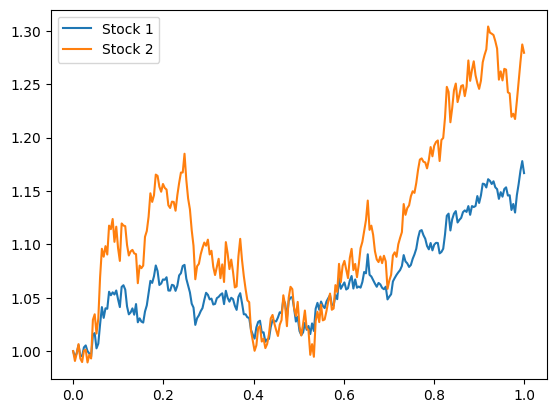

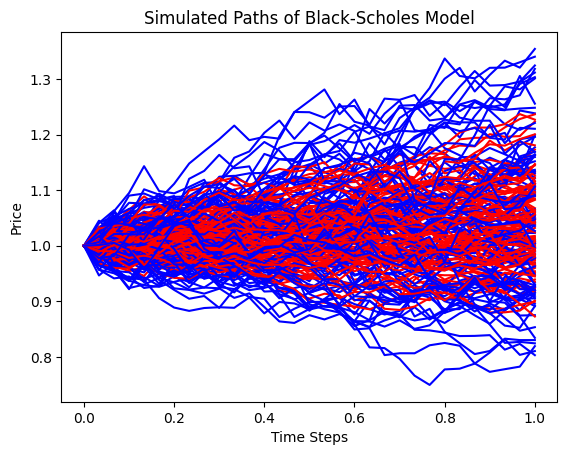

(22400, 30, 2)


In [154]:
##### trying new BS


corr_matrix = log_returns.corr()
rho = corr_matrix.iloc[0, 1]  # Correlation between XOM and CVX
times = np.linspace(0, 1, num=252)  # Simulate for 1 year with daily steps

# Simulate 2d-BS
def simulate2dBS(S0,mus,sigmas,rho,times):
    dts = np.diff(times)
    len_dts = len(dts)
    S = np.zeros((len_dts+1,2))
    S[0,:] = S0
    cov_mat = np.array([[1,rho],
                        [rho,1]])
    for t in range(len_dts):
        dt = dts[t]
        drift = (mus-0.5*(sigmas**2))*dt
        vol = sigmas*np.random.multivariate_normal([0,0],cov_mat*np.sqrt(dt))
        S[t+1,:] = S[t,:]*np.exp(drift+vol)
    return S





S0 = data.iloc[-1].values
S0 = np.array([1, 1])
mus = np.array([0.04,0.05])
sigmas = np.array([0.03,0.05])
path = simulate2dBS(S0,mus,sigmas,rho,times)
plt.plot(times,path)
plt.legend(["Stock 1","Stock 2"])
plt.show()
T=1
M=30
times = np.linspace(0,T,M*T+1)
mus = np.array([0.04,0.05])
sigmas = np.array([0.03,0.05])
correlation = log_returns.corr().iloc[0, 1]
rho = correlation
numpaths = 100
paths = [simulate2dBS(S0,mus,sigmas,rho,times) for i in range(numpaths)]

for path in paths:
    plt.plot(times,path[:,0],color="red")
    plt.plot(times,path[:,1],color="blue")
plt.title('Simulated Paths of Black-Scholes Model')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.show()
print(np.shape(forecast_paths))

In [155]:


# Download stock data
stock_names = ['XOM', 'CVX']
data = yf.download(stock_names, start="2021-01-01", end="2024-08-01")['Adj Close']

# Convert prices to log returns
log_returns = np.log(data / data.shift(1)).dropna()

# Extract initial stock prices (latest prices)
S0 = data.iloc[-1].values


# Calculate mean returns
mean_returns = log_returns.mean()

# Calculate volatilities (standard deviation of returns)
volatilities = log_returns.std()

# Calculate correlation between the stocks
correlation = log_returns.corr().iloc[0, 1]

# Parameters for Black-Scholes Simulation
T=1
M=30
times = np.linspace(0,T,M*T+1)
#mus = mean_returns.values
mus = np.array([0.04,0.05])
sigmas = np.array([0.03,0.05])
rho = correlation

# Helper functions for Black-Scholes and option pricing
def Phi(x):
    return norm.cdf(x)

def d1(St,Tt,sigmas,rho,star=(True,1)):
    S = St[0]/St[1]
    cov = np.prod(sigmas)*rho
    if star[0]:
        S = (S/star[1])*np.exp(-cov*Tt)
    sig = np.sqrt(np.sum(np.square(sigmas))-2*cov)
    _d1 = (np.log(S)+0.5*Tt*sig**2)/(sig*np.sqrt(Tt))
    return _d1

def d2(St,Tt,sigmas,rho,star=(True,1)):
    cov = np.prod(sigmas)*rho
    sig = np.sqrt(np.sum(np.square(sigmas))-2*cov)
    _d1 = d1(St,Tt,sigmas,rho,star=(True,1))
    _d2 = _d1 - sig*np.sqrt(Tt)
    return _d2


def O2payoff(path):
    return np.max([path[-1,0]-path[-1,1],0])

def PriceO2(St,Tt,sigmas,rho):
    return St[0]*Phi(d1(St,Tt,sigmas,rho,star=(False,1)))-St[1]*Phi(d2(St,Tt,sigmas,rho,star=(False,1)))

def HedgeO2path(path,sigmas,rho,times):
    delta_S = np.diff(path,axis=0)
    Tts = times[-1]-times
    V = PriceO2(path[0,:],Tts[0],sigmas,rho)
    H = O2payoff(path)
    for i in range(len(delta_S)):
        Tt = Tts[i]
        St = path[i,:]
        delta_1 = Phi(d1(St,Tt,sigmas,rho,star=(False,1)))
        delta_2 = -Phi(d2(St,Tt,sigmas,rho,star=(False,1)))
        V+= delta_1*delta_S[i,0]+delta_2*delta_S[i,1]
    PNL = V-H
    return PNL





[*********************100%***********************]  2 of 2 completed


In [156]:
#print(np.shape(paths))
#paths = np.array(paths)
#Phi(d1(paths,Tt,sigmas,rho,star=(False,1)))
t=0
point_paths=forecast_paths[:,t,:]
#print(np.shape(point_maths))
#print(path)
#print(point_paths[1,])
#Print(St)
#delta_1 = Phi(d1(St,Tt,sigmas,rho,star=(False,1)))
#delta_2 = -Phi(d2(St,Tt,sigmas,rho,star=(False,1)))
num_points = len(point_paths)
delta_array = np.zeros((num_points, 2))
Tts = times[-1]-times
for i in range(len(point_paths[1])):
  Tt = Tts[i]
  St = point_paths[i,:]
  delta_1 = Phi(d1(St,Tt,sigmas,rho,star=(False,1)))
  delta_2 = -Phi(d2(St,Tt,sigmas,rho,star=(False,1)))
  delta_array[i, 0] = delta_1
  delta_array[i, 1] = delta_2



phi_price=point_paths*delta_array

H0 = np.sum(phi_price, axis=1)[0]
V0=H0

#print(forecast_paths[:,20,:])
#print(V0)

print(np.shape(forecast_paths))
print(H0)

(22400, 30, 2)
0.029513296271426903


The grid search Final code

Data Splitting

In [465]:
forecast_paths_train      = forecast_paths[0:10000,:,:]
forecast_paths_validation = forecast_paths[10000:12400,:,:]
forecast_paths_test       = forecast_paths[12400:17400,:,:]



The PNL's for BS and MVH using the train paths

The optimal NN with validation (with regularisation)

Training with f-act: relu, g-act: relu, lr: 0.001
Epoch [1/20], Train Loss: 4.3448, Validation Loss: 3.7841
Epoch [2/20], Train Loss: 3.7540, Validation Loss: 3.3019
Epoch [3/20], Train Loss: 3.2684, Validation Loss: 2.9226
Epoch [4/20], Train Loss: 2.8861, Validation Loss: 2.6407
Epoch [5/20], Train Loss: 2.6017, Validation Loss: 2.4469
Epoch [6/20], Train Loss: 2.4060, Validation Loss: 2.3278
Epoch [7/20], Train Loss: 2.2853, Validation Loss: 2.2658
Epoch [8/20], Train Loss: 2.2221, Validation Loss: 2.2407
Epoch [9/20], Train Loss: 2.1960, Validation Loss: 2.2321
Epoch [10/20], Train Loss: 2.1868, Validation Loss: 2.2237
Epoch [11/20], Train Loss: 2.1778, Validation Loss: 2.2051
Epoch [12/20], Train Loss: 2.1587, Validation Loss: 2.1707
Epoch [13/20], Train Loss: 2.1239, Validation Loss: 2.1199
Epoch [14/20], Train Loss: 2.0727, Validation Loss: 2.0556
Epoch [15/20], Train Loss: 2.0079, Validation Loss: 1.9824
Epoch [16/20], Train Loss: 1.9344, Validation Loss: 1.9060
Epoch [17/20], 

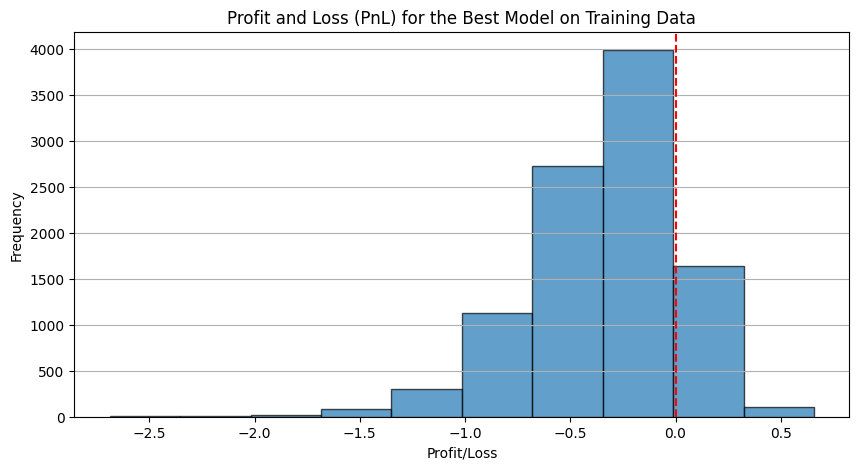

In [158]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Assuming you have your stock paths and other relevant data defined
# forecast_paths_train, forecast_paths_validation, H0, etc.

# Scaling the stock paths
scaler = StandardScaler()
stock_paths_train_scaled = scaler.fit_transform(forecast_paths_train.reshape(-1, forecast_paths_train.shape[-1])).reshape(forecast_paths_train.shape)
stock_paths_validation_scaled = scaler.transform(forecast_paths_validation.reshape(-1, forecast_paths_validation.shape[-1])).reshape(forecast_paths_validation.shape)

# Convert to tensors after scaling
train_paths_tensor = torch.tensor(stock_paths_train_scaled, dtype=torch.float32)
val_paths_tensor = torch.tensor(stock_paths_validation_scaled, dtype=torch.float32)

time_to_maturity_tensor = torch.tensor(np.arange(train_paths_tensor.shape[1], 0, -1), dtype=torch.float32).unsqueeze(-1)

# Payoff H for training and validation
H_train = torch.maximum(train_paths_tensor[:, -1, 0] - train_paths_tensor[:, -1, 1], torch.tensor(0.0))
H_val = torch.maximum(val_paths_tensor[:, -1, 0] - val_paths_tensor[:, -1, 1], torch.tensor(0.0))

# V0 for training and validation
V0_train = torch.tensor([H0] * train_paths_tensor.shape[0], dtype=torch.float32)  # Example initial capital
V0_val = torch.tensor([H0] * val_paths_tensor.shape[0], dtype=torch.float32)  # Example initial capital for validation

# Activation functions
activation_functions = {
    'relu': nn.ReLU(),
    'sigmoid': nn.Sigmoid(),
    'tanh': nn.Tanh()
}

# Define the HedgeRatioNetwork
class HedgeRatioNetwork(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, activation):
        super(HedgeRatioNetwork, self).__init__()
        self.hidden_layers = nn.ModuleList()
        self.hidden_layers.append(nn.Linear(input_size, hidden_sizes[0]))
        self.hidden_layers.append(nn.Linear(hidden_sizes[0], hidden_sizes[1]))
        self.output_layer = nn.Linear(hidden_sizes[1], output_size)
        self.activation = activation

    def forward(self, x):
        for layer in self.hidden_layers:
            x = self.activation(layer(x))
        x = self.output_layer(x)
        return x

# Define the PathNetwork
class PathNetwork(nn.Module):
    def __init__(self, stock_input_size, hidden_sizes, output_size, hedge_ratio_net):
        super(PathNetwork, self).__init__()
        self.hedge_ratio_net = hedge_ratio_net

    def forward(self, stock_paths, time_to_maturity):
        all_phis = []
        for path_idx in range(stock_paths.shape[0]):
            phis_for_path = []
            for t in range(stock_paths.shape[1]):
                stock_prices = stock_paths[path_idx, t, :].unsqueeze(0)
                time_t = time_to_maturity[t].unsqueeze(0)
                input_features = torch.cat([stock_prices, time_t], dim=-1)
                phis = self.hedge_ratio_net(input_features)
                phis_for_path.append(phis)
            phis_for_path = torch.cat(phis_for_path, dim=0)
            all_phis.append(phis_for_path)
        all_phis = torch.stack(all_phis, dim=0)
        return all_phis

# Custom loss function with L1 regularization
def custom_loss(stock_paths, predicted_phis, V0, H, model, lambda_l1=0.01):
    V_T = V0.clone()
    for path_idx in range(stock_paths.shape[0]):
        for t in range(1, stock_paths.shape[1]):
            stock1_change = stock_paths[path_idx, t, 0] - stock_paths[path_idx, t - 1, 0]
            stock2_change = stock_paths[path_idx, t, 1] - stock_paths[path_idx, t - 1, 1]
            phi1 = predicted_phis[path_idx, t, 0]
            phi2 = predicted_phis[path_idx, t, 1]
            V_T[path_idx] += phi1 * stock1_change + phi2 * stock2_change

    mse_loss = torch.mean((V_T - H) ** 2)
    l1_loss = sum(p.abs().sum() for p in model.parameters())
    total_loss = mse_loss + lambda_l1 * l1_loss
    return total_loss

# Store final losses and parameter combinations
final_losses = []
best_params_per_combination = {}

hidden_sizes = [25, 25]
num_epochs = 20
weight_decay = 0.01
learning_rates = [0.001, 0.01, 0.1]

# Grid search over activation functions and learning rates
for f_act_name, f_act in activation_functions.items():
    for g_act_name, g_act in activation_functions.items():
        best_loss_for_combination = float('inf')
        best_val_loss_for_combination = float('inf')
        best_lr_for_combination = None
        
        for lr in learning_rates:
            print(f'Training with f-act: {f_act_name}, g-act: {g_act_name}, lr: {lr}')

            hedge_ratio_net = HedgeRatioNetwork(input_size=3, hidden_sizes=hidden_sizes, output_size=2, activation=g_act)
            path_net = PathNetwork(stock_input_size=2, hidden_sizes=hidden_sizes, output_size=2, hedge_ratio_net=hedge_ratio_net)
            optimizer = optim.Adam(path_net.parameters(), lr=lr, weight_decay=weight_decay)

            # Early stopping parameters
            patience = 5
            best_val_loss = float('inf')
            patience_counter = 0

            # Lists to store losses for plotting
            train_losses = []
            val_losses = []

            # Training loop with early stopping
            for epoch in range(num_epochs):
                path_net.train()
                predicted_phis_train = path_net(train_paths_tensor, time_to_maturity_tensor)

                # Fit the scaler on predicted phis (reshape to 2D)
                phis_scaler = StandardScaler()
                phis_scaler.fit(predicted_phis_train.detach().numpy().reshape(-1, 2))

                loss_train = custom_loss(train_paths_tensor, predicted_phis_train, V0_train, H_train, path_net)

                optimizer.zero_grad()
                loss_train.backward()
                optimizer.step()

                # Validation step
                path_net.eval()
                with torch.no_grad():
                    predicted_phis_val = path_net(val_paths_tensor, time_to_maturity_tensor)
                    loss_val = custom_loss(val_paths_tensor, predicted_phis_val, V0_val, H_val, path_net)

                train_losses.append(loss_train.item())
                val_losses.append(loss_val.item())

                print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {loss_train.item():.4f}, Validation Loss: {loss_val.item():.4f}')

                if loss_val < best_val_loss:
                    best_val_loss = loss_val
                    patience_counter = 0
                else:
                    patience_counter += 1

                if patience_counter >= patience:
                    print(f'Early stopping at epoch {epoch + 1}')
                    break

            # Update best loss for the combination if the loss is lower
            if loss_train.item() < best_loss_for_combination:
                best_loss_for_combination = loss_train.item()
                best_val_loss_for_combination = best_val_loss
                best_lr_for_combination = lr

        best_params_per_combination[(f_act_name, g_act_name)] = (best_loss_for_combination, best_val_loss_for_combination, best_lr_for_combination)

# Print the best parameters for each combination
for (f_act_name, g_act_name), (train_loss, val_loss, lr) in best_params_per_combination.items():
    print(f"Best for f-act: {f_act_name}, g-act: {g_act_name} -> Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, lr: {lr}")


# Prepare data for plotting
labels = []
train_losses = []
val_losses = []

best_train_loss = float('inf')
best_val_loss = float('inf')
best_train_label = None
best_val_label = None

for (f_act_name, g_act_name), (train_loss, val_loss, lr) in best_params_per_combination.items():
    label = f"[{lr if lr % 1 != 0 else int(lr)}, {g_act_name}, {f_act_name}, {hidden_sizes}, {hidden_sizes}]"
    labels.append(label)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    # Update best losses and their labels
    if train_loss < best_train_loss:
        best_train_loss = train_loss
        best_train_label = label
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_val_label = label

# Convert to numpy arrays for easier indexing
train_losses = np.array(train_losses)
val_losses = np.array(val_losses)





# Step 1: Find the best combination based on validation loss
best_combination = min(best_params_per_combination, key=lambda x: best_params_per_combination[x][1])  # key is validation loss
best_f_act_name, best_g_act_name = best_combination
best_lr = best_params_per_combination[best_combination][2]

print(f"Best Activation Functions: {best_f_act_name}, {best_g_act_name}, lr: {best_lr}")

# Step 2: Train the model again using the entire training dataset
hedge_ratio_net = HedgeRatioNetwork(input_size=3, hidden_sizes=hidden_sizes, output_size=2, activation=activation_functions[best_g_act_name])
path_net = PathNetwork(stock_input_size=2, hidden_sizes=hidden_sizes, output_size=2, hedge_ratio_net=hedge_ratio_net)
optimizer = optim.Adam(path_net.parameters(), lr=best_lr, weight_decay=weight_decay)

# Training loop for final model
num_epochs_final = 300  # Increased for better fitting
train_losses_final = []
val_losses_final = []

for epoch in range(num_epochs_final):
    path_net.train()
    predicted_phis_train = path_net(train_paths_tensor, time_to_maturity_tensor)

    # Fit the scaler on predicted phis (reshape to 2D)
    phis_scaler = StandardScaler()
    phis_scaler.fit(predicted_phis_train.detach().numpy().reshape(-1, 2))

    # Unscale phis for calculating V_T
    predicted_phis_train_unscaled = phis_scaler.inverse_transform(predicted_phis_train.detach().numpy().reshape(-1, 2)).reshape(predicted_phis_train.shape)

    loss_train = custom_loss(train_paths_tensor, predicted_phis_train, V0_train, H_train, path_net)

    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()

    train_losses_final.append(loss_train.item())

    # Validation phase
    path_net.eval()
    with torch.no_grad():
        predicted_phis_val = path_net(val_paths_tensor, time_to_maturity_tensor)

        # Fit the scaler on predicted phis for unscaling
        phis_scaler.fit(predicted_phis_val.detach().numpy().reshape(-1, 2))
        
        # Unscale the predicted phis
        predicted_phis_val_unscaled = phis_scaler.inverse_transform(predicted_phis_val.detach().numpy().reshape(-1, 2)).reshape(predicted_phis_val.shape)

        # Calculate validation loss
        loss_val = custom_loss(val_paths_tensor, predicted_phis_val, V0_val, H_val, path_net)
        val_losses_final.append(loss_val.item())

    if (epoch + 1) % 10 == 0:  # Print every 10 epochs
        print(f'Epoch [{epoch + 1}/{num_epochs_final}], Train Loss: {loss_train.item():.4f}, Validation Loss: {loss_val.item():.4f}')

# Step 3: Calculate V_T using the fitted model on the training data
path_net.eval()
with torch.no_grad():
    predicted_phis_train = path_net(train_paths_tensor, time_to_maturity_tensor)
    
    # Fit the scaler on predicted phis for unscaling
    phis_scaler = StandardScaler()
    phis_scaler.fit(predicted_phis_train.detach().numpy().reshape(-1, 2))

    # Unscale the predicted phis
    predicted_phis_train_unscaled = phis_scaler.inverse_transform(predicted_phis_train.detach().numpy().reshape(-1, 2)).reshape(predicted_phis_train.shape)

    # Initialize V_T based on initial capital
    V_T_train = V0_train.clone()
    for path_idx in range(train_paths_tensor.shape[0]):
        for t in range(1, train_paths_tensor.shape[1]):
            stock1_change = train_paths_tensor[path_idx, t, 0] - train_paths_tensor[path_idx, t - 1, 0]
            stock2_change = train_paths_tensor[path_idx, t, 1] - train_paths_tensor[path_idx, t - 1, 1]
            phi1 = predicted_phis_train_unscaled[path_idx, t, 0]
            phi2 = predicted_phis_train_unscaled[path_idx, t, 1]
            V_T_train[path_idx] += phi1 * stock1_change + phi2 * stock2_change

# Calculate PnL using training data
PnL_best = V_T_train - H_train

# Plotting PnL for training data
plt.figure(figsize=(10, 5))
plt.hist(PnL_best.numpy(), bins=10, alpha=0.7, edgecolor='black')
plt.title('Profit and Loss (PnL) for the Best Model on Training Data')
plt.xlabel('Profit/Loss')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.axvline(0, color='red', linestyle='--')
plt.show()


C:\Users\Student\AppData\Local\Temp\ipykernel_1324\3775062387.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


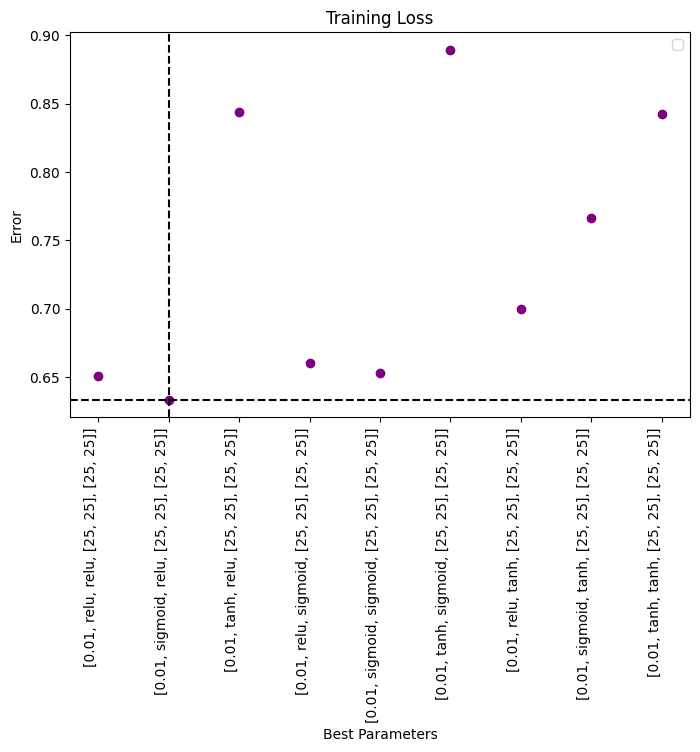

C:\Users\Student\AppData\Local\Temp\ipykernel_1324\3775062387.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


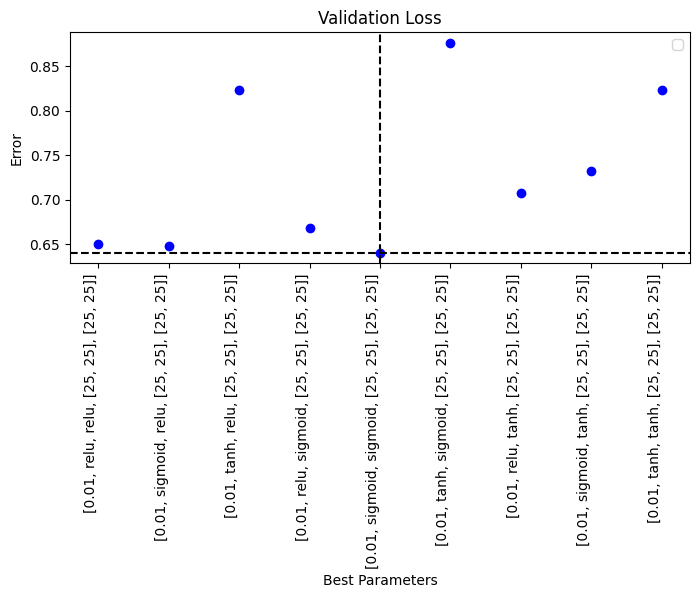

In [462]:
# Plotting Training Losses
plt.figure(figsize=(8, 5))
plt.scatter(labels, train_losses, color='purple')
plt.axhline(y=best_train_loss, color='black', linestyle='--')
plt.axvline(x=best_train_label, color='black', linestyle='--')
plt.title('Training Loss')
plt.xlabel('Best Parameters')
plt.ylabel('Error')
plt.xticks(rotation=90, ha='right')
plt.legend()
plt.show()

# Plotting Validation Losses
plt.figure(figsize=(8, 3))
plt.scatter(labels, val_losses, color='blue')
plt.axhline(y=best_val_loss, color='black', linestyle='--')
plt.axvline(x=best_val_label, color='black', linestyle='--')
plt.title('Validation Loss')
plt.xlabel('Best Parameters')
plt.ylabel('Error')
plt.xticks(rotation=90, ha='right')
plt.legend()
plt.show()

PNLs for all test paths with best parameters: tensor([0.0187, 0.0232, 0.0115,  ..., 0.0116, 0.0219, 0.0344])


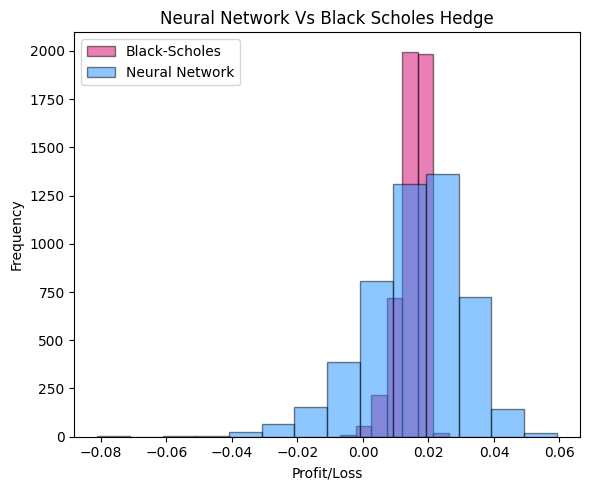

In [161]:
# Prepare test data
test_stock_paths_tensor = torch.tensor(forecast_paths_test, dtype=torch.float32)
test_time_to_maturity_tensor = torch.tensor(np.arange(test_stock_paths_tensor.shape[1], 0, -1), dtype=torch.float32).unsqueeze(-1)

# Initialize V_T with the initial portfolio value V0 for each path
V_T_test = torch.tensor([H0] * test_stock_paths_tensor.shape[0], dtype=torch.float32)  # Example initial capital for test set

# Evaluate the model on the test set
path_net.eval()
with torch.no_grad():
    predicted_phis_test = path_net(test_stock_paths_tensor, test_time_to_maturity_tensor)

# Unscale predicted phis for the test set
phis_scaler = StandardScaler()
phis_scaler.fit(predicted_phis_test.detach().numpy().reshape(-1, 2))
predicted_phis_test_unscaled = phis_scaler.inverse_transform(predicted_phis_test.detach().numpy().reshape(-1, 2)).reshape(predicted_phis_test.shape)

# Initialize V_T with the initial portfolio value V0 for each path in the test set
V_T_test = torch.tensor([H0] * test_stock_paths_tensor.shape[0], dtype=torch.float32).clone()

# Loop over each test path
for path_idx in range(test_stock_paths_tensor.shape[0]):
    for t in range(1, test_stock_paths_tensor.shape[1]):
        stock1_change_test = test_stock_paths_tensor[path_idx, t, 0] - test_stock_paths_tensor[path_idx, t - 1, 0]
        stock2_change_test = test_stock_paths_tensor[path_idx, t, 1] - test_stock_paths_tensor[path_idx, t - 1, 1]

        phi1_test = predicted_phis_test_unscaled[path_idx, t, 0]
        phi2_test = predicted_phis_test_unscaled[path_idx, t, 1]

        V_T_test[path_idx] += phi1_test * stock1_change_test + phi2_test * stock2_change_test

# Calculate the payoff H_T based on the final stock prices for each path in the test set
H_T_test = torch.maximum(test_stock_paths_tensor[:, -1, 0] - test_stock_paths_tensor[:, -1, 1], torch.tensor(0.0))

# Calculate PNLs: PNL = V_T - H_T
PNLs_test = V_T_test - H_T_test

print(f"PNLs for all test paths with best parameters: {PNLs_test}")

# Black Scholes hedging using testing paths
PNLs_BS_test = [HedgeO2path(path, sigmas, rho, times) for path in forecast_paths_test]

# Plot the PnL for the test set
plt.figure(figsize=(6, 5))



# Plotting the PnL from the benchmark (e.g., Black-Scholes)
plt.hist(PNLs_BS_test, bins=7, alpha=0.5, edgecolor='black', color='#D5006D', label='Black-Scholes')  # Dark Pink
# Plotting the PnL from your model
plt.hist(PNLs_test.numpy(), bins=14, edgecolor='black', alpha=0.5, color='#1E90FF', label='Neural Network')  # Dark Sky Blue



# Title and labels
plt.title('Neural Network Vs Black Scholes Hedge')
plt.xlabel('Profit/Loss')
plt.ylabel('Frequency')

# Adding a grid and legend
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()

In [162]:
# Assuming PNLs_test and PNLs_BS_test are already defined as tensors or arrays
PNLs_test_mean = np.mean(PNLs_test.numpy())
PNLs_test_variance = np.var(PNLs_test.numpy())

PNLs_BS_test_mean = np.mean(PNLs_BS_test)
PNLs_BS_test_variance = np.var(PNLs_BS_test)

print(f"PNLs_test: Mean = {PNLs_test_mean}, Variance = {PNLs_test_variance}")
print(f"PNLs_BS_test: Mean = {PNLs_BS_test_mean}, Variance = {PNLs_BS_test_variance}")

PNLs_test: Mean = 0.0158526711165905, Variance = 0.00022353425447363406
PNLs_BS_test: Mean = 0.014948481180348418, Variance = 1.6652492319085187e-05


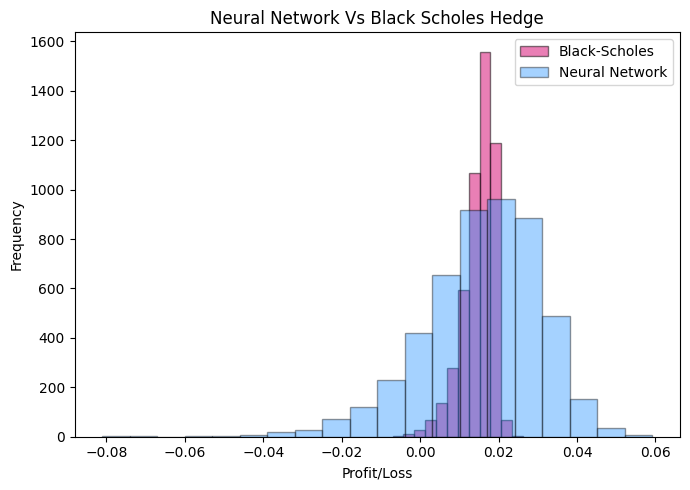

In [485]:
plt.figure(figsize=(7, 5))

# Plotting the PnL from your model
plt.hist(PNLs_BS_test, bins=12, alpha=0.5, edgecolor='black', color='#D5006D', label='Black-Scholes')  # Dark Pink

plt.hist(PNLs_test.numpy(), bins=20, edgecolor='black', alpha=0.4, color='#1E90FF', label='Neural Network')  # Dark Sky Blue

# Plotting the PnL from the benchmark (e.g., Black-Scholes)

# Title and labels
plt.title('Neural Network Vs Black Scholes Hedge')
plt.xlabel('Profit/Loss')
plt.ylabel('Frequency')

# Adding a grid and legend
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()

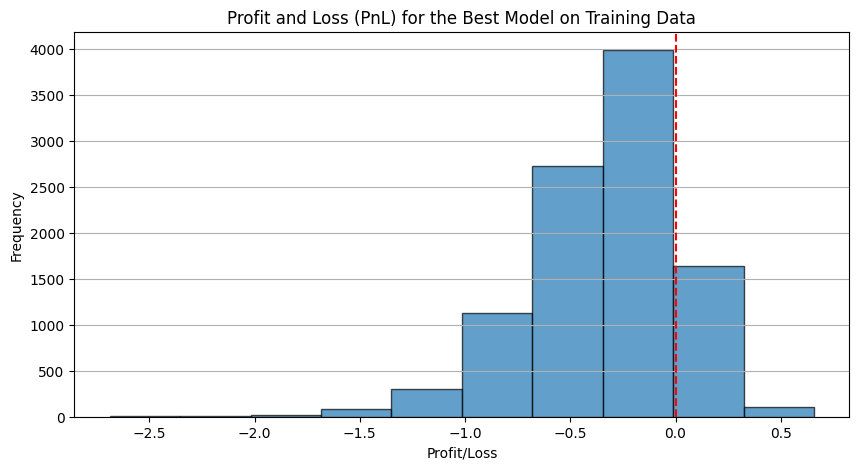

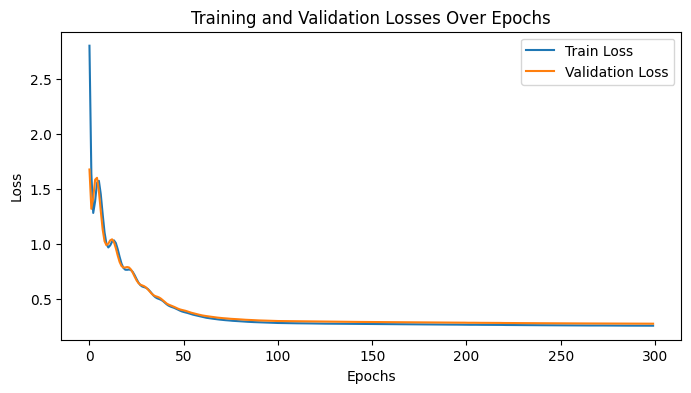

In [488]:
# Plotting PnL for training data
plt.figure(figsize=(10, 5))
plt.hist(PnL_best.numpy(), bins=10, alpha=0.7, edgecolor='black')
plt.title('Profit and Loss (PnL) for the Best Model on Training Data')
plt.xlabel('Profit/Loss')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.axvline(0, color='red', linestyle='--')
plt.show()

# Optionally, you can also plot the training and validation losses
plt.figure(figsize=(8, 4))
plt.plot(train_losses_final, label='Train Loss')
plt.plot(val_losses_final, label='Validation Loss')
plt.title('Training and Validation Losses Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [478]:

test_data_1 = test_data.to_numpy().reshape(1, 22, 2)

first_price = test_data_1[:, 0, :]

#test_data_1=test_data_1/first_price

#print(test_data_1)




# Prepare test data
test_stock_paths_tensor = torch.tensor(test_data_1, dtype=torch.float32)
test_time_to_maturity_tensor = torch.tensor(np.arange(test_stock_paths_tensor.shape[1], 0, -1), dtype=torch.float32).unsqueeze(-1)

# Initialize V_T with the initial portfolio value V0 for each path
V_T_test = torch.tensor([H0] * test_stock_paths_tensor.shape[0], dtype=torch.float32)  # Example initial capital for test set

# Evaluate the model on the test set
path_net.eval()
with torch.no_grad():
    predicted_phis_test = path_net(test_stock_paths_tensor, test_time_to_maturity_tensor)

# Unscale predicted phis for the test set
phis_scaler = StandardScaler()
phis_scaler.fit(predicted_phis_test.detach().numpy().reshape(-1, 2))
predicted_phis_test_unscaled = phis_scaler.inverse_transform(predicted_phis_test.detach().numpy().reshape(-1, 2)).reshape(predicted_phis_test.shape)



#print((predicted_phis_test))




t=0
point_paths=test_data_1[:,t,:]
num_points = len(point_paths)
delta_array = np.zeros((num_points, 2))
Tts = times[-1]-times
for i in range(1):
  Tt = Tts[i]
  St = point_paths[i,:]
  delta_1 = Phi(d1(St,Tt,sigmas,rho,star=(False,1)))
  delta_2 = -Phi(d2(St,Tt,sigmas,rho,star=(False,1)))
  delta_array[i, 0] = delta_1
  delta_array[i, 1] = delta_2



phi_price=point_paths*delta_array

H0 = np.sum(phi_price, axis=1)[0]
V0=H0
#print(V0)
# Choose a path index to visualize (e.g., the first path)
path_index = 0


first_price = test_data.iloc[0, :]
#test_data=test_data/first_price

path = test_data

#print(path[1, :, :])
# Extract V_T values over time for the selected path
V_T_values =    [V0] #[V0_train[path_index].item()]  # Start with the initial capital

# Recalculate V_T over time for the chosen path
for t in range(1, path.shape[0]):
    stock1_change = path.iloc[ t, 0] - path.iloc[ t - 1, 0]
    stock2_change = path.iloc[ t, 1] - path.iloc[ t - 1, 1]
    phi1 = predicted_phis_test_unscaled[0, t, 0]
    phi2 = predicted_phis_test_unscaled[0, t, 1]
    new_value = V_T_values[t-1] + phi1 * stock1_change + phi2 * stock2_change
    V_T_values.append(new_value)
    
    









# Initialize the path


In [479]:

def PriceO2(St,Tt,sigmas,rho):
    return St[0]*Phi(d1(St,Tt,sigmas,rho,star=(False,1)))-St[1]*Phi(d2(St,Tt,sigmas,rho,star=(False,1)))



# Initialize the list to store values at each time step
V_T_BS_values = [PriceO2(path.iloc[0, :], Tts[0], sigmas, rho)]  # Initial value for time 0
V_T_values_BS = [V_T_BS_values[0]] #[V_T_BS_values[0]]  # Start V_T_values with the initial value
V_T_values_BS = [None] * path.shape[0]  # Preallocate with None or initial values

# Initialize the first value
V_T_values_BS[0] = V_T_BS_values[0]


#print(path.shape[0])
# Loop through time steps
# Loop through time steps
for t in range(1, path.shape[0]):
    stock1_change = path.iloc[t, 0] - path.iloc[t - 1, 0]
    stock2_change = path.iloc[t, 1] - path.iloc[t - 1, 1]
    Tt = Tts[t]  # Remaining time for the current time step
    St = path.iloc[t, :]  # Current stock prices

    # Calculate option deltas
    delta_1 = Phi(d1(St, Tt, sigmas, rho, star=(False, 1)))
    delta_2 = -Phi(d2(St, Tt, sigmas, rho, star=(False, 1)))

    # Update the value
    V = V_T_values_BS[t-1]+delta_1 * stock1_change + delta_2 * stock2_change

    # Append to V_T_values for tracking
    #V_T_values_BS.append(V) 
    V_T_values_BS[t]=V
    


# Output the computed values
#print(V_T_values_BS)

H_ = np.maximum(test_data_1[path_index, -1, 0] - test_data_1[path_index, -1, 1], [0])


C:\Users\Student\AppData\Local\Temp\ipykernel_1324\4249592041.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return St[0]*Phi(d1(St,Tt,sigmas,rho,star=(False,1)))-St[1]*Phi(d2(St,Tt,sigmas,rho,star=(False,1)))
C:\Users\Student\AppData\Local\Temp\ipykernel_1324\2839609648.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  S = St[0]/St[1]


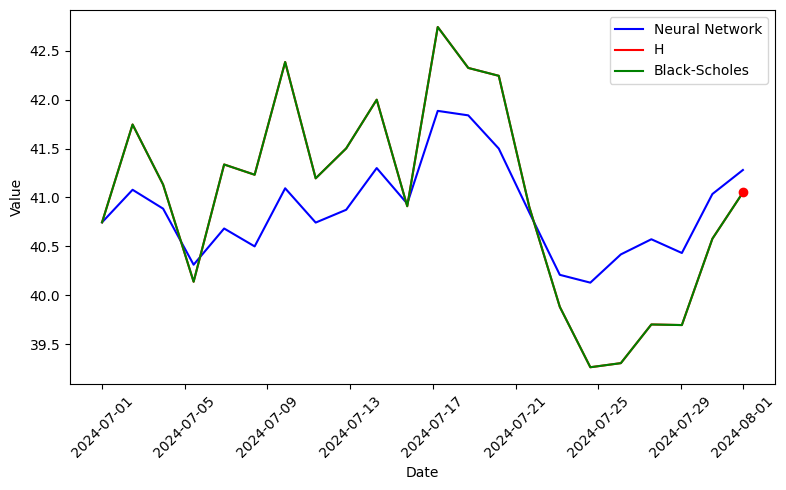

In [486]:
date_range = pd.date_range(start='2024-07-01', end='2024-08-01', periods=len(V_T_values))
# Plotting
plt.figure(figsize=(8, 5))

# Plot the values for Neural Network
plt.plot(date_range,  V_T_values, color='blue', label='Neural Network')

# Plot the values for Black-Scholes
#print(V_T_BS_values)
# Highlight point H
H_ = np.maximum(test_data_1[path_index, :, 0] - test_data_1[path_index, :, 1], 0)
#plt.scatter( H_, color='red', label='H', zorder=5)  # Highlight point H

plt.plot(date_range, H_, linestyle='-', color='red', label='H')
plt.plot(date_range,V_T_values_BS, linestyle='-', color='green', label='Black-Scholes')

H_ = np.maximum(test_data_1[path_index, -1, 0] - test_data_1[path_index, -1, 1], 0)

plt.scatter(date_range[-1], [H_], color='red', zorder=5)
# Add titles and labels
#plt.title('Value Time Series')
plt.xlabel('Date')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()